# Frequency Analysis

In this notebook, we explore the frequency of each access request in the synthetic access log. \
According with the first researches, we identify three
properties to take advantage in this new model.
* Hierarchy
* Noisy access requests
* Projections


In [1]:
### Import libraries

import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt

In [2]:
### User and resource attributes for each dataset

DS_ID = "IoT" # Availables => user_attributes.keys()
OUT_FILE = open(DS_ID+".output", "w") # File to save the outputs

USER_ATTRS = {"IoT": ["role", "age", "health", "uname"],
              "AMZ": ["MGR_ID","ROLE_ROLLUP_1","ROLE_ROLLUP_2","ROLE_DEPTNAME","ROLE_TITLE","ROLE_FAMILY_DESC","ROLE_FAMILY","ROLE_CODE"],
              "HC": ["position", "uward", "specialties", "teams", "agentfor", "uname"],
              "UN": ["position","departmentu","crsTaken","crsTaught","isChair", "uname"],
              "PM": ["adminroles","projects","departmentu","projectsled","expertiseu","isemployee","task","uname"]}

RES_ATTRS = {"IoT": ["area", "mode", "temperature", "lockstatus", "rname"],
             "AMZ":["RID"],
             "HC": ["type", "author", "patient", "topics", "tratingTeam", "rward", "rname"],
             "UN": ["type","student","department","csr", "rname"],
             "PM": ["type","project","department","expertise","proprietary", "rname"]}

EDG_ATTRS = {"IoT": ["uname", "rname", "location", "timeday", "op", "ACTION"],
             "AMZ": ["uname", "rname"],
             "HC": ["uname", "rname"],
             "UN":["uname", "rname"],
             "PM":["uname", "rname"]}


In [3]:
### Load dataset file

filename = "../data/IoT-expo-universal.csv"

acc_log = pd.read_csv(filename)

# Remove first column (is the old index)
acc_log = acc_log[acc_log.columns[1:]]

# Change the uname string values to int values
acc_log = acc_log.replace(acc_log.uname.unique(), range(len(acc_log.uname.unique())))

# Change the resource id
acc_log["rname"] = acc_log["rname"] + max(acc_log.uname.unique()) + 1

print("Done!")
print(acc_log.head(5)) # Show the first five rows

OUT_FILE.write("***** "+DS_ID+" Output information *****\n\n") # Title of the document

# Delete some variables
del filename

Done!
    role  age  health  uname         type        area   mode  temperature  \
0  child    3  health      0  Smart locks  livingroom  armed           25   
1  child    3  health      0           TV     bedroom  armed           35   
2  child    3  health      0  Smart locks    backyard  night           15   
3  child    3  health      0           TV     bedroom  armed          -10   
4  child    3  health      0  Smart locks  livingroom  armed            5   

  lockstatus  rname    location   timeday         op  ACTION  
0     locked    134    backyard  midnight  emergency       0  
1     locked    996    backyard     night     access       1  
2   unlocked    307  livingroom     night  emergency       0  
3     locked    978    backyard  midnight  emergency       0  
4   unlocked    127     bedroom  midnight        arm       1  


## Attributes analysis

In [4]:
### User attributes

user_attributes = USER_ATTRS[DS_ID] # User attributes from the current dataset
users = acc_log[user_attributes].drop_duplicates()
users = users.reset_index(drop=True)
print("|U| =", len(users))
OUT_FILE.write("|U| = "+ str(len(users))+ "\n")
users.head()

|U| = 120


,role,age,health,uname
0,child,3,health,0
1,child,3,anormal,1
2,child,3,emergency,2
3,child,5,health,3
4,child,5,anormal,4


In [5]:
### Resource attributes

res_attributes = RES_ATTRS[DS_ID]
resrs = acc_log[res_attributes].drop_duplicates()
resrs = resrs.reset_index(drop=True)
print("|R| =", len(resrs))
OUT_FILE.write("|R| = "+ str(len(resrs))+ "\n")
resrs.head()

|R| = 990


,area,mode,temperature,lockstatus,rname
0,livingroom,armed,25,locked,134
1,bedroom,armed,35,locked,996
2,backyard,night,15,unlocked,307
3,bedroom,armed,-10,locked,978
4,livingroom,armed,5,unlocked,127


In [32]:
# Edges attributes

edges_attributes = EDG_ATTRS[DS_ID]
#edges = acc_log[edges_attributes].drop_duplicates()
#edges = acc_log.value_counts(edges_attributes, normalize=True)
edges = acc_log.value_counts(["uname", "rname"], normalize=True)
edges = edges.reset_index().rename(columns={0: 'weight'}).to_dict(orient='records')
# edges = edges.reset_index(drop=True)
edges = pd.DataFrame(edges)
edges = edges.rename(columns={'proportion': 'weight'})
#edges["weight"] = edges.value_counts(edges_attributes, normalize=True).values
#OUT_FILE.write("|E| = "+ str(len(edges))+ "\n")
edges.head()

,uname,rname,weight
0,0,121,0.000500
1,0,123,0.000473
2,0,161,0.000471
3,0,120,0.000461
4,1,161,0.000423


## Graph contruction

In [34]:
### Create the bipartite graph

# Iteration over tuples in the dataframe
tuple_list = edges.itertuples(index=False)

# Using the TupleList method to build the network
bip_network = ig.Graph.TupleList(tuple_list, directed=False,
                                 edge_attrs=edges.columns[2:].tolist())

# Print summary of the bipartite network
print(bip_network.summary())
#OUT_FILE.write("\nBipartite Graph Summary: \n" + bip_network.summary())

# Check if it is a bipartite network
if bip_network.is_bipartite():
    print("It is bipartite!")
#    OUT_FILE.write("\nIt is bipartite!\n")
else:
    print("The network is not bipartite.")
#    OUT_FILE.write("The network is not bipartite.\n")

#del tuple_list

IGRAPH UNW- 1107 118334 -- 
+ attr: name (v), weight (e)
It is bipartite!


In [35]:
### Add user attributes

# Add type of node:     0=User      1=Resource
user_nodes = bip_network.vs.select(name_le=max(users.uname.unique()))
resource_nodes = bip_network.vs.select(name_gt=max(users.uname.unique()))
user_nodes["type"] = 0
resource_nodes["type"] = 1

# Add attributes
for attr in user_attributes[:-1]:   # User attributes
    user_nodes[attr] = users[attr]
for attr in res_attributes[:-1]:    # Resource attributes
    resource_nodes[attr] = resrs[attr]

# Remove objecto to free memory
del user_nodes, resource_nodes

In [36]:
# Save the graph
bip_network.write(DS_ID + "_bip-graph.graphml")

In [28]:
OUT_FILE.close()

Vamos a agregar como un entero la jerarquia de un usuarios o recurso global.
Qué pasa con los valores iguales? Es decir que la suma de participación es igual.

UN factor puede ser el número de accesos de aristas. Una especia de cobinación
entre el número de aristas y su peso. La más simple es el promedio de suma pero
no creo que sea la mejor

Aprovechar la estructura de la red es una excelente idea y puede proporcionar información valiosa para la asignación de jerarquías en tu grafo. Aquí hay algunas estrategias que puedes considerar para aprovechar la estructura de la red:

1. **Centralidad de Nodo:**
   - Utiliza métricas de centralidad, como la centralidad de grado, la centralidad de intermediación o la centralidad de cercanía. Los nodos con mayor centralidad suelen ocupar posiciones más prominentes en la red y podrían recibir jerarquías más altas.

2. **Conectividad y Comunidades:**
   - Examina la conectividad de los nodos y las comunidades en la red. Los nodos que están altamente conectados o que pertenecen a comunidades bien definidas podrían tener jerarquías más altas.

3. **Estructura Bipartita:**
   - Dado que estás trabajando con un grafo bipartito que representa usuarios y recursos, considera la estructura específica de este tipo de grafos. Podrías aplicar técnicas específicas para grafos bipartitos, como proyecciones unipartitas, para analizar la relación entre usuarios y recursos.

4. **Propagación de Etiquetas:**
   - Aplica algoritmos de propagación de etiquetas o algoritmos de clasificación para asignar jerarquías basadas en la información de nodos cercanos. Estos algoritmos pueden aprovechar la estructura local de la red.

5. **Similitud de Vecinos:**
   - Calcula la similitud entre nodos basada en los vecinos compartidos. Nodos con vecinos similares podrían recibir jerarquías similares.

6. **Diferenciación de Roles:**
   - Analiza si existen roles diferenciados en la red y asigna jerarquías en función de estos roles. Por ejemplo, algunos nodos pueden actuar como "centros" de la red, mientras que otros son más periféricos.

7. **Algoritmos de Clustering:**
   - Aplica algoritmos de clustering para identificar grupos de nodos con estructuras similares. Los nodos dentro del mismo cluster podrían tener jerarquías similares.

8. **Análisis de Caminos Cortos:**
   - Examina los caminos cortos en la red. Nodos que se encuentran en rutas de acceso más cortas entre otros nodos podrían recibir jerarquías más altas.

Al aprovechar la estructura de la red, puedes obtener insights más profundos y contextuales sobre la importancia y jerarquía de los nodos en tu grafo. La elección de la estrategia dependerá de la naturaleza específica de tu grafo y los objetivos de tu análisis. Experimenta con diferentes enfoques y evalúa cómo afectan tus resultados.

## Jerarquía.

In [21]:
### Number of duplicated access requests
print("# Access requests = ", len(acc_log))
print("# Unique Access requests = ", len(acc_log.drop_duplicates()), 
      "({:.2f}%)".format((len(acc_log.drop_duplicates())*100)/len(acc_log)))
difference_acc_req = len(acc_log) - len(acc_log.drop_duplicates())
print("Difference = ", difference_acc_req)

# Access requests =  5702313
# Unique Access requests =  1830385 (32.10%)
Difference =  3871928


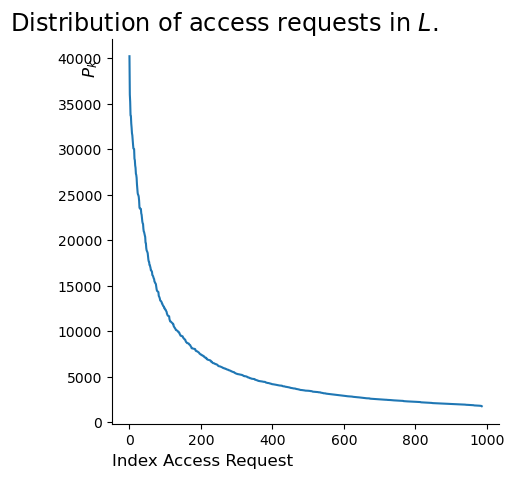

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.spines[['right', 'top']].set_visible(False)
to_plot = acc_log.rname.value_counts()
ax.plot(range(len(to_plot)), to_plot)
ax.set_xlabel('Index Access Request', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large", parse_math=True)
ax.yaxis.set_label_coords(-0.03,0.95)
ax.set_title("Distribution of access requests in $L$.", size="xx-large", x=0.29, y=1, parse_math=True)
plt.show()

In [23]:
to_plot = acc_log.value_counts(["uname", "rname"], normalize=False)
to_plot_dict = to_plot.reset_index().rename(columns={0: 'counts'}).to_dict(orient='records')
pd.DataFrame(to_plot_dict)

,uname,rname,count
0,0,121,2849
1,0,123,2698
2,0,161,2685
3,0,120,2627
4,1,161,2411
...,...,...,...
118329,119,658,1
118330,100,748,1
118331,86,1029,1
118332,114,983,1


Hola te paso la lista de lo que requiero
* El algoritmo genera solicitudes duplicadas?
* El algoritmo genera solicitudes con ruido (misma solicitud con DENY y PERMIT)
<>